In [20]:
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load Dataset
data = pd.read_csv("Merged.csv")

# Display first few rows
print(data.head())

# Check for missing values
print("\n🔍 Missing values before cleaning:\n", data.isnull().sum())

# Drop missing values
data = data.dropna()

# Correct label inconsistencies
label_corrections = {
    "Neutural": "Neutral", "Meutral": "Neutral", "N EUTRAL": "Neutral",
    "NEUTRANEG": "Neutral", "Negetive": "Negative", "NEGNEG": "Negative",
    "Negativee": "Negative", "NEG": "Negative"
}
data['tag'] = data['tag'].replace(label_corrections)

# Remove 'Neutral' rows
data = data[data['tag'] != 'Neutral']

# Identify positive class dynamically
unique_labels = data['tag'].unique()
print("\n🏷️ Unique labels after cleaning:", unique_labels)
positive_class_label = unique_labels[0]

# Balance dataset by removing excess positive rows
positive_class = data[data['tag'] == positive_class_label]
if len(positive_class) >= 8500:
    rows_to_remove = positive_class.sample(n=8500, random_state=42)
    data = data.drop(rows_to_remove.index)

print(f"\n✅ Remaining positive class count: {len(data[data['tag'] == positive_class_label])}")

# Define text and target columns
text_column = 'comment'
target_column = 'tag'

# Split dataset into train and test sets
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)

# Load Bangla stopwords
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-bn/master/stopwords-bn.txt"
response = requests.get(stopwords_url)
if response.status_code == 200:
    stop_words_bangla = set(response.text.splitlines())

    # Remove stopwords from train and test data
    df_train[text_column] = df_train[text_column].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_bangla]))
    df_test[text_column] = df_test[text_column].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_bangla]))

print("\n✅ Step 1: Dataset cleaned successfully!")


                                             comment       tag
0  আলহামদুলিল্লাহ সোনার বাংলার সোনার ছেলেরা দেশকে...  Positive
1                                           মাশাল্লা  Positive
2                                          এগিয়ে যাও  Positive
3                                            চমৎকার।  Positive
4  দেশের শিল্প পতিদের উচিত দেশিও প্রযুক্তি গুলোকে...   Neutral

🔍 Missing values before cleaning:
 comment    0
tag        5
dtype: int64

🏷️ Unique labels after cleaning: ['Positive' 'Negative']

✅ Remaining positive class count: 13770

✅ Step 1: Dataset cleaned successfully!


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000, max_df=0.95, min_df=5)

# Fit and transform the training data, and transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train[text_column])
X_test_tfidf = tfidf_vectorizer.transform(df_test[text_column])

print("\n✅ Step 2: TF-IDF vectorization completed!")



✅ Step 2: TF-IDF vectorization completed!


In [22]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train[target_column])
y_test = label_encoder.transform(df_test[target_column])

print("\n✅ Step 3: Labels encoded successfully!")



✅ Step 3: Labels encoded successfully!


In [23]:
from sklearn.naive_bayes import BernoulliNB

# Initialize the Bernoulli Naïve Bayes model
bnb_model = BernoulliNB()

# Train the model
bnb_model.fit(X_train_tfidf, y_train)

print("\n✅ Step 4: Bernoulli Naïve Bayes model trained successfully!")



✅ Step 4: Bernoulli Naïve Bayes model trained successfully!


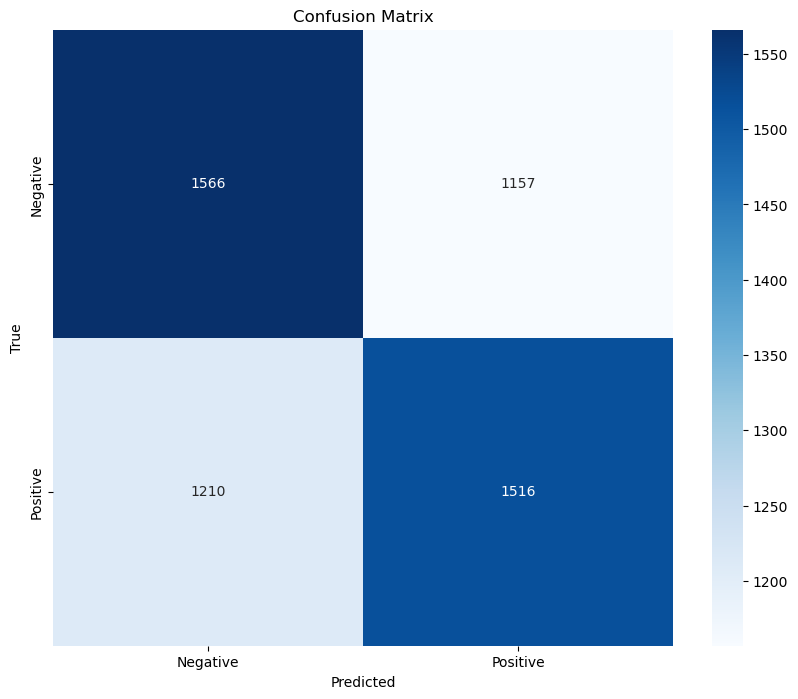


✅ Step 5.1: Confusion Matrix generated!


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred = bnb_model.predict(X_test_tfidf)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_labels = label_encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\n✅ Step 5.1: Confusion Matrix generated!")


In [25]:
from sklearn.metrics import classification_report

# Classification Report
print("\n📝 Classification Report:\n", classification_report(y_test, y_pred))

print("\n✅ Step 5.2: Classification Report generated!")



📝 Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.58      0.57      2723
           1       0.57      0.56      0.56      2726

    accuracy                           0.57      5449
   macro avg       0.57      0.57      0.57      5449
weighted avg       0.57      0.57      0.57      5449


✅ Step 5.2: Classification Report generated!


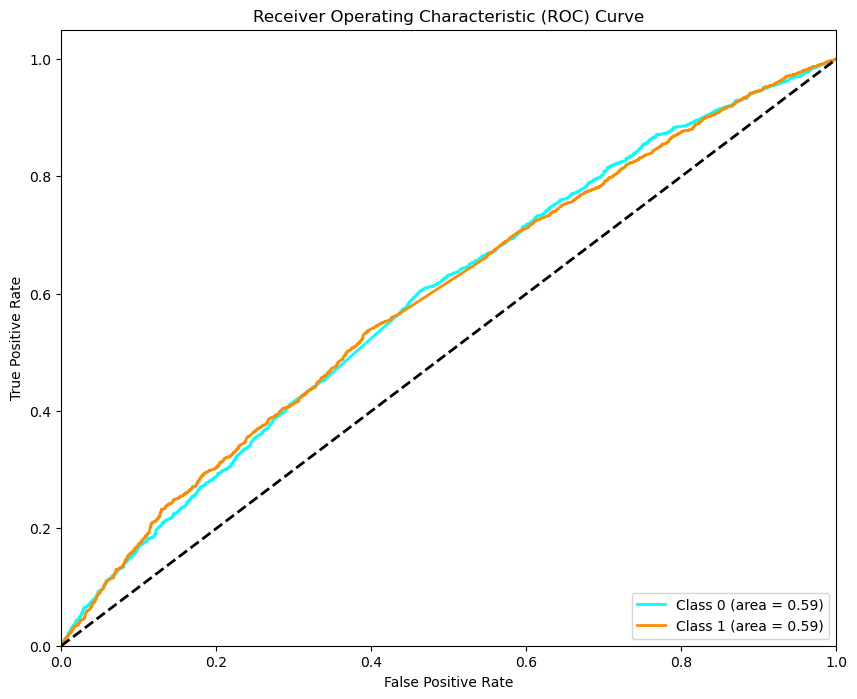


✅ Step 5.3: ROC Curve generated!


In [26]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, bnb_model.predict_proba(X_test_tfidf)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i, color in zip(range(len(label_encoder.classes_)), cycle(['aqua', 'darkorange', 'cornflowerblue'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("\n✅ Step 5.3: ROC Curve generated!")


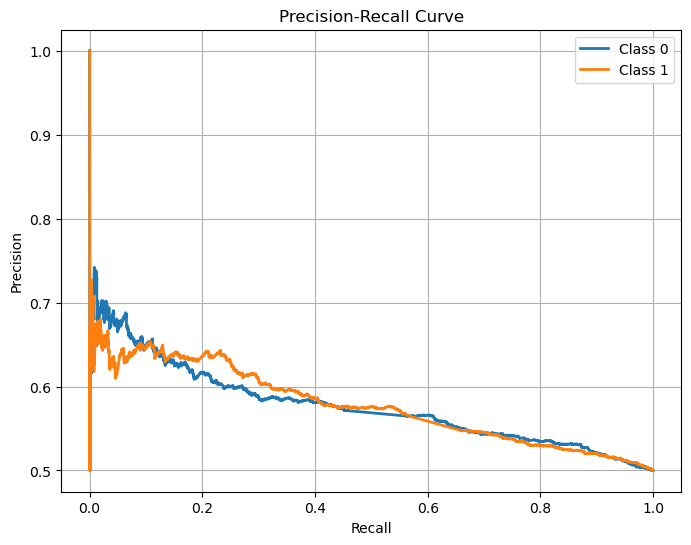


✅ Step 5.4: Precision-Recall Curve generated!


In [27]:
from sklearn.metrics import precision_recall_curve

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    precision, recall, _ = precision_recall_curve(y_test == i, bnb_model.predict_proba(X_test_tfidf)[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

print("\n✅ Step 5.4: Precision-Recall Curve generated!")
